In [1]:
import tensorflow as tf
import numpy as np
from six.moves import cPickle
import matplotlib.pyplot as plt
# this notebook was made in Colaboratory and the model was trained
# with Colaboratory's GPU capabilities
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [0]:
import math

# train/dev approach --> do train/dev/test when we get more data
def load_data(input_path, gt_path, test_size=0.3):

    input_data = np.load(input_path)
    gt = np.load(gt_path)
    m = input_data.shape[0]
    testing_size = int(m*test_size)
    #gets all the images all the way to the last 30%
    train_x = input_data[:-testing_size, :,:]
    train_y = gt[:-testing_size,:,:]
    #gets all the features from the last 30%
    test_x = input_data[m-testing_size:,:, :]
    test_y = gt[m-testing_size:,:,:]
    
    return train_x, train_y, test_x, test_y



def random_mini_batches(X, Y, mini_batch_size = 64):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- ground truth SHAPE TO BE DECIDED DEPENDING ON HOW WE LABEL THE DATA 
    mini_batch_size - size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]  
    print(X.shape, Y.shape)
    # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    
    shuffled_X = X[permutation,:,:]
    shuffled_X = np.expand_dims(shuffled_X, axis=4)
    shuffled_Y = Y[permutation,:,:,:]
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


User uploaded file "binary_grids_30pt.npy" with length 32768080 bytes
User uploaded file "pixel_image_pt.npy" with length 32768080 bytes


In [5]:
for name, data in uploaded.items():
  with open(name, 'wb') as f:
    f.write(data)
    print ('saved file', name)
#get data
input_path = "pixel_image_pt.npy"
gt_path = "binary_grids_30pt.npy"
gt = np.load(gt_path)
gt = gt.reshape(-1)
print(gt.sum(), gt.shape)

saved file binary_grids_30pt.npy
saved file pixel_image_pt.npy
4960.0 (4096000,)


In [8]:
for name, data in uploaded.items():
  with open(name, 'wb') as f:
    f.write(data)
    print ('saved file', name)
#get data
input_path = "pixel_image_pt.npy"
gt_path = "binary_grids_30pt.npy"
train_x, train_y, test_x, test_y = load_data(input_path, gt_path, test_size=0.3)
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

saved file binary_grids_30pt.npy
saved file pixel_image_pt.npy
(700, 64, 64) (700, 64, 64)
(300, 64, 64) (300, 64, 64)


In [0]:
def convert_to_one_hot(Y, C):
    L = np.eye(C)[Y.reshape(-1).astype(int)]
    Y = L.reshape(Y.shape[0], Y.shape[1], Y.shape[2], -1)
    return Y

In [10]:
train_y = convert_to_one_hot(train_y, 2)
test_y = convert_to_one_hot(test_y, 2)
print(train_y.shape)
print(test_y.shape)

(700, 64, 64, 2)
(300, 64, 64, 2)


In [0]:
n_classes = 2
k_size = 3
(n_h, n_w, n_c) = (64, 64, 1)
batch_size = 32
weights = {}
biases = {}
learning_rate = 1e-4
n_epochs = 1000

In [0]:
def create_placeholders(n_h, n_w, n_c, n_classes):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(tf.float32, shape=[None, n_h, n_w, n_c])
    Y = tf.placeholder(tf.int32, shape=[None, n_h, n_w, n_classes])
    
    return X, Y

In [0]:
def create_parameters():

    init = tf.contrib.layers.xavier_initializer_conv2d(dtype=tf.float32)
    initb = tf.constant_initializer(value=0.0, dtype=tf.float32)
    
    weights = {
        "W1_1": tf.get_variable("W1_1", [3, 3, 1, 64], initializer = init),
        "W1_2": tf.get_variable("W1_2", [3, 3, 64, 64], initializer = init),
        "W2_1": tf.get_variable("W2_1", [3, 3, 64, 128], initializer = init),
        "W2_2": tf.get_variable("W2_2", [3, 3, 128, 128], initializer = init),
        "W3_1": tf.get_variable("W3_1", [3, 3, 128, 256], initializer = init),
        "W3_2": tf.get_variable("W3_2", [3, 3, 256, 256], initializer = init),
        "W3_3": tf.get_variable("W3_3", [3, 3, 256, 256], initializer = init),
        "W4_1": tf.get_variable("W4_1", [3, 3, 256, 512], initializer = init),
        "W4_2": tf.get_variable("W4_2", [3, 3, 512, 512], initializer = init),
        "W4_3": tf.get_variable("W4_3", [3, 3, 512, 512], initializer = init),
        "W5_1": tf.get_variable("W5_1", [3, 3, 512, 512], initializer = init),
        "W5_2": tf.get_variable("W5_2", [3, 3, 512, 512], initializer = init),
        "W5_3": tf.get_variable("W5_3", [3, 3, 512, 512], initializer = init),
        "W6": tf.get_variable("W6", [3, 3, 512, 1024], initializer = init),
        "W7": tf.get_variable("W7", [1, 1, 1024, 1024], initializer = init),
        "W8": tf.get_variable("W8", [1, 1, 1024, n_classes], initializer = init),
    }

    biases = {
        "b1_1": tf.get_variable("b1_1", [64], initializer = initb),
        "b1_2": tf.get_variable("b1_2", [64], initializer = initb),
        
        "b2_1": tf.get_variable("b2_1", [128], initializer = initb),
        "b2_2": tf.get_variable("b2_2", [128], initializer = initb),
        
        "b3_1": tf.get_variable("b3_1", [256], initializer = initb),
        "b3_2": tf.get_variable("b3_2", [256], initializer = initb),
        "b3_3": tf.get_variable("b3_3", [256], initializer = initb),
        
        "b4_1": tf.get_variable("b4_1", [512], initializer = initb),
        "b4_2": tf.get_variable("b4_2", [512], initializer = initb),
        "b4_3": tf.get_variable("b4_3", [512], initializer = initb),
        
        "b5_1": tf.get_variable("b5_1", [512], initializer = initb),
        "b5_2": tf.get_variable("b5_2", [512], initializer = initb),
        "b5_3": tf.get_variable("b5_3", [512], initializer = initb),
        
        "b6": tf.get_variable("b6", [1024], initializer = initb),
        
        "b7": tf.get_variable("b7", [1024], initializer = initb),
        
        "b8": tf.get_variable("b8", [n_classes], initializer = initb),
    }
    
    return weights, biases

In [0]:
def DeepLab_architecture(input, weights, biases, keep_prob):

  with tf.device('/gpu:0'):      
    conv1_1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input, weights["W1_1"], strides=[1, 1, 1, 1],padding='SAME'), biases["b1_1"]))
    conv1_2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv1_1, weights["W1_2"], strides=[1, 1, 1, 1],padding='SAME'), biases["b1_2"]))
    pool_1 = tf.nn.max_pool(conv1_2,ksize=[1, k_size, k_size, 1],strides=[1, 2, 2, 1],padding='SAME')

    conv2_1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool_1, weights["W2_1"], strides=[1, 1, 1, 1],padding='SAME'), biases["b2_1"]))
    conv2_2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv2_1, weights["W2_2"], strides=[1, 1, 1, 1],padding='SAME'), biases["b2_2"]))
    pool_2 = tf.nn.max_pool(conv2_2,ksize=[1, k_size, k_size, 1],strides=[1, 2, 2, 1],padding='SAME')

    conv3_1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool_2, weights["W3_1"], strides=[1, 1, 1, 1],padding='SAME'), biases["b3_1"]))
    conv3_2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv3_1, weights["W3_2"], strides=[1, 1, 1, 1],padding='SAME'), biases["b3_2"]))
    conv3_3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv3_2, weights["W3_3"], strides=[1, 1, 1, 1],padding='SAME'), biases["b3_3"]))
    pool_3 = tf.nn.max_pool(conv3_3,ksize=[1, k_size, k_size, 1],strides=[1, 2, 2, 1],padding='SAME')

    conv4_1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool_3, weights["W4_1"], strides=[1, 1, 1, 1],padding='SAME'), biases["b4_1"]))
    conv4_2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv4_1, weights["W4_2"], strides=[1, 1, 1, 1],padding='SAME'), biases["b4_2"]))
    conv4_3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv4_2, weights["W4_3"], strides=[1, 1, 1, 1],padding='SAME'), biases["b4_3"]))
    pool_4 = tf.nn.max_pool(conv4_3,ksize=[1, k_size, k_size, 1],strides=[1, 1, 1, 1],padding='SAME')

    conv5_1 = tf.nn.relu(tf.nn.bias_add(tf.nn.atrous_conv2d(pool_4, weights["W5_1"] , 2, padding='SAME'), biases["b5_1"]))
    conv5_2 = tf.nn.relu(tf.nn.bias_add(tf.nn.atrous_conv2d(conv5_1, weights["W5_2"] , 2, padding='SAME'), biases["b5_2"]))
    conv5_3 = tf.nn.relu(tf.nn.bias_add(tf.nn.atrous_conv2d(conv5_2, weights["W5_3"] , 2, padding='SAME'), biases["b5_3"]))
    pool_5 = tf.nn.max_pool(conv5_3,ksize=[1, k_size, k_size, 1],strides=[1, 1, 1, 1],padding='SAME')
    avg_pool = tf.nn.avg_pool(pool_4, ksize=[1, k_size, k_size, 1], strides=[1, 1, 1, 1], padding='SAME')

    fc6_1 = tf.nn.relu(tf.nn.bias_add(tf.nn.atrous_conv2d(avg_pool, weights["W6"] , 12, padding='SAME'), biases["b6"]))
    drop_1 = tf.nn.dropout(fc6_1, keep_prob=keep_prob)

    fc7_1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(drop_1, weights["W7"], strides=[1, 1, 1, 1], padding='SAME'), biases["b7"]))
    drop_2 = tf.nn.dropout(fc7_1, keep_prob=keep_prob)

    fc8 = tf.nn.bias_add(tf.nn.conv2d(drop_2, weights["W8"], strides=[1, 1, 1, 1], padding='SAME'), biases["b8"])

    return fc8


In [0]:
def compute_cost(X, Y, weights, biases):
    print("Label: ", Y.get_shape().as_list())
    print("Logits: ", X.get_shape().as_list())
    
    prediction = tf.image.resize_images(X, tf.shape(Y)[1:3,])
    prediction = tf.reshape(prediction, [-1, n_classes])
    #gt = tf.image.resize_nearest_neighbor(Y , tf.stack(conv8.get_shape()[1:3]))
    gt = tf.cast(tf.reshape(Y, [-1, n_classes]), tf.float32)
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = prediction, labels = gt))
    return cost

In [0]:
def predict(X, weights, biases):

    prediction = DeepLab_architecture(tf.cast(X, tf.float32),weights, biases, keep_prob=1)
    prediction = tf.image.resize_images(prediction, tf.shape(X)[1:3,])
    prediction = tf.argmax(prediction, dimension=3)

    return tf.cast(prediction, tf.uint8)

In [0]:
#training function
def train(X_train, Y_train, X_test, Y_test, learning_rate = learning_rate,
          num_epochs = n_epochs, minibatch_size = batch_size, print_cost = True,
          keep_prob = 0.5):
    tf.reset_default_graph()
    
    costs = []

    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_h, n_w, n_c, n_classes)
    
    # Initialize parameters
    weights, biases = create_parameters()

    # define pred model
    out = DeepLab_architecture(X, weights, biases,  keep_prob)
    
    # Cost function: Since we are using a binary classification --> sigmoid for now
    cost = compute_cost(out, Y, weights, biases)
    
    # Define optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Define prediction func
    predict_op = predict(X, weights, biases)
    
    # Define evaluation metrics
    correct = tf.equal(tf.cast(predict_op, tf.int64), tf.argmax(Y,dimension=3))
    accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
    confusion = tf.contrib.metrics.confusion_matrix(tf.reshape(predict_op, [-1]), tf.reshape(tf.argmax(Y,dimension=3), [-1]), num_classes=2)

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(tf.global_variables_initializer())
        sess.run(tf.initialize_local_variables())
        
        n_samples = X_train.shape[0]
        # Do the training loop
        for epoch in range(num_epochs):
            
            minibatch_cost = 0.
            num_minibatches = int(n_samples / minibatch_size)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
            i = 1
            for minibatch in minibatches:
                #print('minibatch number '+str(i)+' in epoch : '+str(epoch))
                i += 1
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch

                _ , temp_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
            print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        #predict_op = tf.expand_dims(predict_op, axis = -1)
        #mIoU, update_op = tf.contrib.metrics.streaming_mean_iou(predict_op, Y, num_classes=2) 


        mean_iou, _ = tf.contrib.metrics.streaming_mean_iou(predict_op, tf.argmax(Y, dimension=3), num_classes=2)
        #X_test = np.expand_dims(X_test, axis = -1)
        #Y_test = np.expand_dims(Y_test, axis = -1)
        #preds, _ = sess.run([predict_op, update_op], feed_dict={X: X_test, Y: Y_test})
        
        X_test = np.expand_dims(X_test, axis = -1)
        print('Accuracy =', accuracy.eval({X: X_test, Y: Y_test}))
        print('confusion:')
        print(confusion.eval({X: X_test, Y: Y_test}))
        ### FOR SOME REASON THIS IS NOT WORKING
        ### FOLLOWED THIS BUT STILL DOESN'T WORK: https://github.com/tensorflow/tensorflow/issues/4331
        ###accuracy_increment, iou_increment = sess.run([predict_op, mean_iou], feed_dict={ X: X_test, Y: Y_test})
        ###print('Mean IoU: {:.3f}'.format(mIoU.eval(session=sess)))
        
        return "belle"

Label:  [None, 64, 64, 2]
Logits:  [None, 8, 8, 2]
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use `tf.local_variables_initializer` instead.
(700, 64, 64) (700, 64, 64, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Cost after epoch 0: 0.265476
Cost after epoch 0: 0.265476
(700, 64, 64) (700, 64, 64, 2)
Cost after epoch 1: 0.026670
(700, 64, 64) (700, 64, 64, 2)
Cost after epoch 2: 0.018587
(700, 64, 64) (700, 64, 64, 2)
Cost after epoch 3: 0.017369
(700, 64, 64) (700, 64, 64, 2)
Cost after epoch 4: 0.016547
(700, 64, 64) (700, 64, 64, 2)
Cost after epoch 5: 0.015756
Cost after epoch 5: 0.015756
(700, 64, 64) (700, 64, 64, 2)
Cost after epoch 6: 0.015219
(700, 64, 64) (700, 64, 64, 2)
Cost after epoch 7: 0.013945
(700, 64, 64) (700, 64, 64, 2)
Cost after epoch 8: 0.012142
(700, 64, 64) (700, 64, 64, 2)
Cost after epoch 9: 0.010199


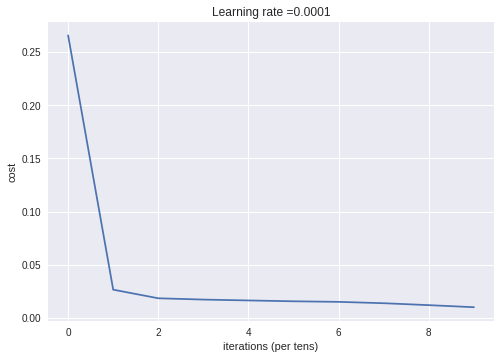

Accuracy = 0.9985425
confusion:
[[1227009    1791]
 [      0       0]]


In [18]:
_ = train(train_x, train_y, test_x, test_y, learning_rate = learning_rate,
          num_epochs = 10, minibatch_size = batch_size, print_cost = True,
          keep_prob = 0.5)
                  